In [48]:
import os
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, precision_score, recall_score, f1_score


In [49]:
# Creating directories for saving models and images
os.makedirs("Models", exist_ok=True)
os.makedirs("Images", exist_ok=True)

In [50]:
#Loading the dataset
file_path = "Dataset/web-page-phishing.csv" 
df = pd.read_csv(file_path)

In [51]:
df.head()

,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,n_space,n_tilde,n_comma,n_plus,n_asterisk,n_hastag,n_dollar,n_percent,n_redirection,phishing
0,37,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,77,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,126,4,1,2,0,1,3,0,2,0,0,0,0,0,0,0,0,0,1,1
3,18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,55,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [52]:
df.tail()

,url_length,n_dots,n_hypens,n_underline,n_slash,n_questionmark,n_equal,n_at,n_and,n_exclamation,n_space,n_tilde,n_comma,n_plus,n_asterisk,n_hastag,n_dollar,n_percent,n_redirection,phishing
100072,23,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100073,34,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
100074,70,2,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100075,28,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100076,16,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
df.isnull().sum()

url_length        0
n_dots            0
n_hypens          0
n_underline       0
n_slash           0
n_questionmark    0
n_equal           0
n_at              0
n_and             0
n_exclamation     0
n_space           0
n_tilde           0
n_comma           0
n_plus            0
n_asterisk        0
n_hastag          0
n_dollar          0
n_percent         0
n_redirection     0
phishing          0
dtype: int64

In [54]:
#Separating features and target variable
X = df.drop(columns=['phishing'])  # Features
y = df['phishing']  # Target (0 = legitimate, 1 = phishing)

In [55]:
#Spliting dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [56]:
#Standardizing the feature values for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
#Saving the scaler in the Models folder
joblib.dump(scaler, "Models/scaler.joblib")

['Models/scaler.joblib']

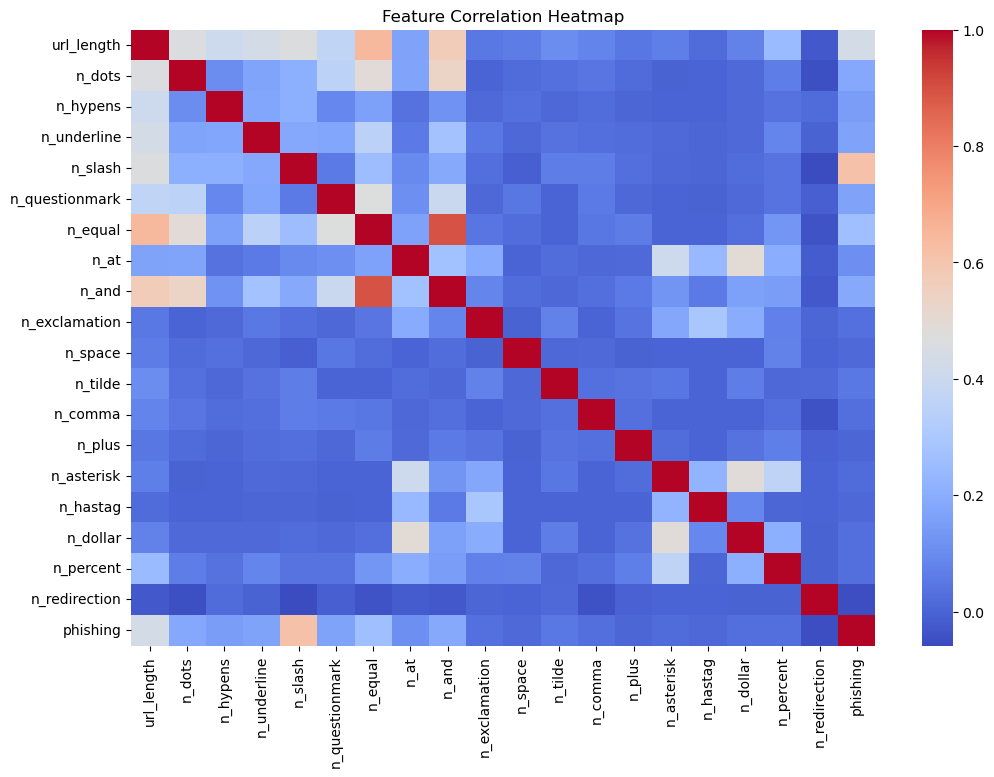

In [58]:
#Ploting and Saving Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.savefig("Images/heatmap.png")
plt.show()
plt.close()


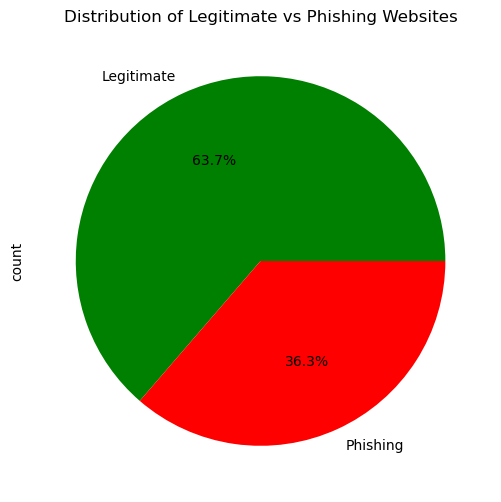

In [59]:
#Pie Chart of Phishing vs. Legitimate
plt.figure(figsize=(6, 6))
df["phishing"].value_counts().plot.pie(
    autopct="%1.1f%%", labels=["Legitimate", "Phishing"], colors=["green", "red"]
)
plt.title("Distribution of Legitimate vs Phishing Websites")
plt.savefig("Images/pie_chart.png")
plt.show()
plt.close()

In [60]:
#Defining Models and Hyperparameter Grid
models = {
    "Decision Tree": (DecisionTreeClassifier(), {
        'max_depth': [5, 10, 20, None],
        'criterion': ['gini', 'entropy']
    }),
    "KNN": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }),
    "Logistic Regression": (LogisticRegression(), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    }),
    "Random Forest": (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None]
    }),
    "SVM": (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    "Naive Bayes": (GaussianNB(), {})  # No hyperparameters for tuning
}

In [61]:
#Storing results for comparison plots
results = {
    "Model": [],
    "Accuracy": [],
    "R-squared": [],
    "Adjusted R-squared": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}


In [62]:
#Training models and evaluate
for name, (model, param_grid) in models.items():
    print(f"Training {name} model...")

    if param_grid:
        # Perform Hyperparameter Tuning
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        best_model = model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    # Save trained model in Models folder
    model_filename = f"Models/{name.replace(' ', '_')}.joblib"
    joblib.dump(best_model, model_filename)
    print(f"{name} model saved as {model_filename}\n")

    # 🔹 Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate", "Phishing"], yticklabels=["Legitimate", "Phishing"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.savefig(f"Images/confusion_matrix_{name.replace(' ', '_')}.png")
    plt.close()

    # Store results for comparison plots
    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["R-squared"].append(r2)
    results["Adjusted R-squared"].append(adj_r2)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-score"].append(f1)

Training Decision Tree model...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 20}
Decision Tree Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     12743
           1       0.86      0.81      0.84      7273

    accuracy                           0.88     20016
   macro avg       0.88      0.87      0.87     20016
weighted avg       0.88      0.88      0.88     20016

Decision Tree model saved as Models/Decision_Tree.joblib

Training KNN model...
Best parameters for KNN: {'n_neighbors': 7, 'weights': 'uniform'}
KNN Accuracy: 0.8884
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     12743
           1       0.86      0.83      0.84      7273

    accuracy                           0.89     20016
   macro avg       0.88      0.88      0.88     20016
weighted avg       0.89      0.89      0.89     20016

KNN model saved as Models/KNN.joblib

Trai

In [63]:
# Converting results to DataFrame
results_df = pd.DataFrame(results)

In [64]:
#Ploting and Saving Accuracy Comparison
plt.figure(figsize=(10, 8))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.savefig("Images/accuracy_comparison.png")
plt.close()

In [65]:
#Ploting and Saving R-Squared Comparison
plt.figure(figsize=(10, 8))
sns.barplot(x="Model", y="R-squared", data=results_df)
plt.title("Model R-Squared Comparison")
plt.xticks(rotation=45)
plt.savefig("Images/r_squared_comparison.png")
plt.close()

In [66]:
#Ploting and Saving Adjusted R-Squared Comparison
plt.figure(figsize=(10, 8))
sns.barplot(x="Model", y="Adjusted R-squared", data=results_df)
plt.title("Model Adjusted R-Squared Comparison")
plt.xticks(rotation=45)
plt.savefig("Images/adjusted_r_squared_comparison.png")
plt.close()

In [67]:
#Ploting and Saving Precision, Recall, and F1-score Comparison
metrics = ["Precision", "Recall", "F1-score"]
for metric in metrics:
    plt.figure(figsize=(10, 8))
    sns.barplot(x="Model", y=metric, data=results_df)
    plt.title(f"Model {metric} Comparison")
    plt.xticks(rotation=45)
    plt.savefig(f"Images/{metric.lower()}_comparison.png")
    plt.close()

print("All models trained, optimized, and saved successfully! Performance metrics and visualizations are in 'Images/' folder.")

All models trained, optimized, and saved successfully! Performance metrics and visualizations are in 'Images/' folder.
